In [1]:
import numpy as np
import h5py
from pathlib import Path
import json
import matplotlib.pyplot as plt

# Deep learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Scikit-learn for preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-04-02 10:14:58.846680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 10:15:00.214775: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-02 10:15:00.450905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743614100.711182 3861277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743614101.110900 3861277 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743614102.509634 3861277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
class EventReader:
    """Handles reading and preprocessing of particle physics event data."""
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        
        # Define feature lists based on README
        self.electron_features_list = [
            'electron_E', 'electron_pt', 'electron_eta', 'electron_phi',
            'electron_time',
            'electron_d0', 'electron_z0', 'electron_dpt',
            'electron_nPIX', 'electron_nMissingLayers',
            'electron_chi2', 'electron_numberDoF',
            'electron_f1', 'electron_f3', 'electron_z'
        ]
        
        self.photon_features_list = [
            'photon_E', 'photon_pt', 'photon_eta', 'photon_phi',
            'photon_time',
            'photon_maxEcell_E',
            'photon_f1', 'photon_f3', 'photon_r1', 'photon_r2',
            'photon_etas1', 'photon_phis1', 'photon_z'
        ]

        # Group electron features by type
        self.electron_feature_groups = {
            'kinematics': [0, 1],         # E, pt - positive valued, potentially skewed
            'angles': [2, 3],             # eta, phi - special circular treatment
            'time': [4],                  # time - potentially outlier-sensitive
            'track_params': [5, 6, 7],    # d0, z0, dpt - potentially outlier-sensitive
            'count_data': [8, 9],         # nPIX, nMissingLayers - discrete values
            'quality': [10, 11],          # chi2, numberDoF - potentially skewed
            'shower_shape': [12, 13],     # f1, f3 - shape, ratios, potentially saturated
            'position': [14]              # z - potentially normal distribution
        }
        
        # Group photon features by type
        self.photon_feature_groups = {
            'kinematics': [0, 1],         # E, pt - positive valued, potentially skewed
            'angles': [2, 3],             # eta, phi - special circular treatment
            'time': [4],                  # time - potentially outlier-sensitive
            'energy_cell': [5],           # maxEcell_E - potentially skewed  
            'shower_shape': [6, 7, 8, 9, 10, 11],  # f1, f3, r1, r2, etas1, phis1
            'position': [12]              # z - potentially normal distribution
        }

        # Initialize scalers for each group
        self.initialize_scalers()

        # Load and preprocess all data
        self.load_all_data()
    def initialize_scalers(self):
        """Initialize specialized scalers for each feature group."""
        # Electron scalers
        self.electron_scalers = {
            'kinematics': PowerTransformer(method='yeo-johnson', standardize=True),  # For positive, skewed data
            'angles': MinMaxScaler(feature_range=(-1, 1)),        # For angular variables
            'time': RobustScaler(),                               # Handle outliers
            'track_params': RobustScaler(),                       # Handle outliers
            'count_data': StandardScaler(),                       # For discrete data
            'quality': PowerTransformer(method='yeo-johnson', standardize=True),  # For skewed data
            'shower_shape': StandardScaler(),                     # For shape data
            'position': StandardScaler()                          # For positions
        }
        
        # Photon scalers
        self.photon_scalers = {
            'kinematics': PowerTransformer(method='yeo-johnson', standardize=True),  # For positive, skewed data
            'angles': MinMaxScaler(feature_range=(-1, 1)),        # For angular variables
            'time': RobustScaler(),                               # Handle outliers
            'energy_cell': PowerTransformer(method='yeo-johnson', standardize=True),  # For energy, likely skewed
            'shower_shape': StandardScaler(),                     # For shape data
            'position': StandardScaler()                          # For positions
        }
        
        # Vertex scalers (simple case - 3 features)
        self.vertex_scaler = StandardScaler()
        
    def load_all_data(self, max_files=70):
        """Load and preprocess data from HDF5 files."""
        print("Loading all data...")
        
        # Initialize as None for first file
        self.electron_features = None
        self.photon_features = None
        self.vertex_features = None
        
        file_count = 0
        
        for file_path in self.data_dir.glob("*.h5"):
            if file_count >= max_files:
                break
                
            with h5py.File(file_path, 'r', rdcc_nbytes=10*1024*1024) as f:
                n_events = len(f['events/PV_x'])
                print(f"Processing {file_path.name}: {n_events} events")
                
                # Load all data at once
                electrons = {feat: f[f'events/electrons/{feat}'][:] for feat in self.electron_features_list}
                photons = {feat: f[f'events/photons/{feat}'][:] for feat in self.photon_features_list}
                vertices = np.stack([
                    f['events/PV_x'][:],
                    f['events/PV_y'][:],
                    f['events/PV_z'][:]
                ], axis=1)
                
                # Process all events at once
                e_mask = (electrons['electron_E'] > 0) & (f[f'events/electrons/electron_LHValue'][:] > -5)
                
                # Initialize arrays for all events
                e_feats = np.zeros((n_events, 4, len(self.electron_features_list)))
                p_feats = np.zeros((n_events, 4, len(self.photon_features_list)))
                
                # Process all events at once
                for feat_idx, feat in enumerate(self.electron_features_list):
                    e_feats[..., feat_idx] = electrons[feat]
                    e_feats[..., feat_idx] = np.where(e_mask, e_feats[..., feat_idx], 0)  # Zero out electrons failing selection
                
                for feat_idx, feat in enumerate(self.photon_features_list):
                    p_feats[..., feat_idx] = photons[feat]

                # Apply event filtering: Require at least two objects
                electron_count = np.sum(e_feats[:, :, 0] > 0, axis=1)
                photon_count = np.sum(p_feats[:, :, 0] > 0, axis=1)
                total_count = electron_count + photon_count

                # Create mask for events with at least 2 objects
                valid_events = total_count >= 2
                
                # Apply the filter
                e_feats = e_feats[valid_events]
                p_feats = p_feats[valid_events]
                vertices = vertices[valid_events]

                # Add to main arrays
                if self.electron_features is None:
                    self.electron_features = e_feats
                    self.photon_features = p_feats
                    self.vertex_features = vertices
                else:
                    self.electron_features = np.concatenate([self.electron_features, e_feats])
                    self.photon_features = np.concatenate([self.photon_features, p_feats])
                    self.vertex_features = np.concatenate([self.vertex_features, vertices])
                
                file_count += 1
                print(f"Processed {file_count} files, total events: {len(self.electron_features):,}")
        
        print(f"\nFinal dataset:")
        print(f"Total files processed: {file_count}")
        print(f"Total events: {len(self.electron_features):,}")
        print(f"Shapes: electrons {self.electron_features.shape}, photons {self.photon_features.shape}, vertices {self.vertex_features.shape}")
        
        # Fit and apply specialized scalers
        print("\nFitting and applying specialized scalers...")
        self._fit_transform_features()

        print(f"Final dataset: {len(self.electron_features):,} events")
        print(f"Shapes: electrons {self.electron_features.shape}, photons {self.photon_features.shape}, vertices {self.vertex_features.shape}")    
        
    def _fit_transform_features(self):
        """Fit and transform features using specialized scalers."""
        # Create working copies to avoid modifying originals during processing
        e_feats_transformed = self.electron_features.copy()
        p_feats_transformed = self.photon_features.copy()
        
        # Process electron features by group
        for group_name, feature_indices in self.electron_feature_groups.items():
            # Get all feature data for this group at once
            group_values = np.column_stack([
                self.electron_features[:, :, idx].reshape(-1, 1) 
                for idx in feature_indices
            ])
            
            # Fit and transform all features in the group together
            transformed_values = self.electron_scalers[group_name].fit_transform(group_values)
            
            # Split back into individual features and update
            for i, feat_idx in enumerate(feature_indices):
                feat_transformed = transformed_values[:, i].reshape(
                    self.electron_features.shape[0], self.electron_features.shape[1]
                )
                e_feats_transformed[:, :, feat_idx] = feat_transformed
        
        # Process photon features by group
        for group_name, feature_indices in self.photon_feature_groups.items():
            # Get all feature data for this group at once
            group_values = np.column_stack([
                self.photon_features[:, :, idx].reshape(-1, 1) 
                for idx in feature_indices
            ])
            
            # Fit and transform all features in the group together
            transformed_values = self.photon_scalers[group_name].fit_transform(group_values)
            
            # Split back into individual features and update
            for i, feat_idx in enumerate(feature_indices):
                feat_transformed = transformed_values[:, i].reshape(
                    self.photon_features.shape[0], self.photon_features.shape[1]
                )
                p_feats_transformed[:, :, feat_idx] = feat_transformed
        
        # For vertices, simple standard scaling
        self.vertex_features = self.vertex_scaler.fit_transform(self.vertex_features)
        
        # Update features with transformed versions
        self.electron_features = e_feats_transformed
        self.photon_features = p_feats_transformed
    
    def transform_new_data(self, electron_features, photon_features, vertex_features):
        """Transform new data using fitted scalers."""
        # Create working copies
        e_feats_transformed = electron_features.copy()
        p_feats_transformed = photon_features.copy()
        
        # Process electron features by group
        for group_name, feature_indices in self.electron_feature_groups.items():
            # Get all feature data for this group at once
            group_values = np.column_stack([
                electron_features[:, :, idx].reshape(-1, 1) 
                for idx in feature_indices
            ])
            
            # Transform all features in the group together
            transformed_values = self.electron_scalers[group_name].transform(group_values)
            
            # Split back into individual features and update
            for i, feat_idx in enumerate(feature_indices):
                feat_transformed = transformed_values[:, i].reshape(
                    electron_features.shape[0], electron_features.shape[1]
                )
                e_feats_transformed[:, :, feat_idx] = feat_transformed
        
        # Process photon features by group
        for group_name, feature_indices in self.photon_feature_groups.items():
            # Get all feature data for this group at once
            group_values = np.column_stack([
                photon_features[:, :, idx].reshape(-1, 1) 
                for idx in feature_indices
            ])
            
            # Transform all features in the group together
            transformed_values = self.photon_scalers[group_name].transform(group_values)
            
            # Split back into individual features and update
            for i, feat_idx in enumerate(feature_indices):
                feat_transformed = transformed_values[:, i].reshape(
                    photon_features.shape[0], photon_features.shape[1]
                )
                p_feats_transformed[:, :, feat_idx] = feat_transformed
        
        # For vertices, simple standard scaling
        v_feats_transformed = self.vertex_scaler.transform(vertex_features)
        
        return e_feats_transformed, p_feats_transformed, v_feats_transformed
    
    def get_train_val_test_split(self, val_size=0.33, test_size=0.33, shuffle=True):
        """Split data into train, validation, and test sets."""
        indices = np.arange(len(self.vertex_features))
        if shuffle:
            np.random.shuffle(indices)
            
        # Calculate split points
        test_split = int(len(indices) * (1 - test_size))
        val_split = int(len(indices) * (1 - test_size - val_size))
        
        # Split indices
        train_idx = indices[:val_split]
        val_idx = indices[val_split:test_split]
        test_idx = indices[test_split:]
        
        # Create split datasets
        train_data = (
            self.electron_features[train_idx],
            self.photon_features[train_idx],
            self.vertex_features[train_idx]
        )
        
        val_data = (
            self.electron_features[val_idx],
            self.photon_features[val_idx],
            self.vertex_features[val_idx]
        )
        
        test_data = (
            self.electron_features[test_idx],
            self.photon_features[test_idx],
            self.vertex_features[test_idx]
        )
        
        return train_data, val_data, test_data
        
    def save_scalers(self, output_dir):
        """Save scaler parameters for later use."""
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # Save electron scalers
        electron_scaler_params = {}
        for group_name, scaler in self.electron_scalers.items():
            # Save relevant parameters based on scaler type
            params = {}
            # Save scaler type
            params['type'] = scaler.__class__.__name__
            # Save feature indices this scaler applies to
            params['feature_indices'] = self.electron_feature_groups[group_name]
            
            # Add parameters specific to each scaler type
            if isinstance(scaler, StandardScaler):
                params['mean'] = scaler.mean_.tolist()
                params['scale'] = scaler.scale_.tolist()
            
            elif isinstance(scaler, RobustScaler):
                params['center'] = scaler.center_.tolist()
                params['scale'] = scaler.scale_.tolist()
            
            elif isinstance(scaler, MinMaxScaler):
                params['feature_range'] = scaler.feature_range
                params['min_'] = scaler.min_.tolist()
                params['scale_'] = scaler.scale_.tolist()
            
            elif isinstance(scaler, PowerTransformer):
                params['lambdas'] = scaler.lambdas_.tolist()
                params['method'] = scaler.method
                params['standardize'] = scaler.standardize
                if scaler.standardize:
                    params['mean'] = scaler._scaler.mean_.tolist()
                    params['scale'] = scaler._scaler.scale_.tolist()

            electron_scaler_params[group_name] = params
        
        # Save photon scalers
        photon_scaler_params = {}
        for group_name, scaler in self.photon_scalers.items():
            # Save relevant parameters based on scaler type
            params = {}
            # Save scaler type
            params['type'] = scaler.__class__.__name__
            # Save feature indices this scaler applies to
            params['feature_indices'] = self.photon_feature_groups[group_name]
            
            # Add parameters specific to each scaler type
            if isinstance(scaler, StandardScaler):
                params['mean'] = scaler.mean_.tolist()
                params['scale'] = scaler.scale_.tolist()
            
            elif isinstance(scaler, RobustScaler):
                params['center'] = scaler.center_.tolist()
                params['scale'] = scaler.scale_.tolist()
            
            elif isinstance(scaler, MinMaxScaler):
                params['feature_range'] = scaler.feature_range
                params['min_'] = scaler.min_.tolist()
                params['scale_'] = scaler.scale_.tolist()
            
            elif isinstance(scaler, PowerTransformer):
                params['lambdas'] = scaler.lambdas_.tolist()
                params['method'] = scaler.method
                params['standardize'] = scaler.standardize
                if scaler.standardize:
                    params['mean'] = scaler._scaler.mean_.tolist()
                    params['scale'] = scaler._scaler.scale_.tolist()
            
            # elif isinstance(scaler, QuantileTransformer):
            #     params['quantiles'] = scaler.quantiles_.tolist()
            #     params['n_quantiles'] = scaler.n_quantiles_
            #     params['output_distribution'] = scaler.output_distribution
            #     params['ignore_implicit_zeros'] = scaler.ignore_implicit_zeros
            #     params['subsample'] = scaler.subsample
            #     params['random_state'] = scaler.random_state if scaler.random_state is not None else None
            #     params['references'] = scaler.references_
            
            photon_scaler_params[group_name] = params
        
        # Save vertex scaler
        vertex_scaler_params = {
            'mean': self.vertex_scaler.mean_.tolist(),
            'scale': self.vertex_scaler.scale_.tolist(),
            'type': self.vertex_scaler.__class__.__name__
        }
        
        # Combine all scaler parameters
        scaler_params = {
            'electron': electron_scaler_params,
            'photon': photon_scaler_params,
            'vertex': vertex_scaler_params,
            'electron_features_list': self.electron_features_list,
            'photon_features_list': self.photon_features_list
        }
        
        with open(output_dir / 'scaler_params.json', 'w') as f:
            json.dump(scaler_params, f, indent=2)
        
        print(f"Saved scaler parameters to {output_dir / 'scaler_params.json'}")

In [3]:
# Test data loading and preprocessing
data_dir = "/fs/ddn/sdf/group/atlas/d/hjia625/VLL-DP/VLL_classifier/hdf5_output"
reader = EventReader(data_dir)
reader.save_scalers("./output")

Loading all data...
Processing data_00440543.f1321_m2153_p6000.43297168._000780.trees.h5: 7291 events
Processed 1 files, total events: 7,105
Processing data_00440499.f1321_m2153_p6000.43297168._000704.trees.h5: 354255 events
Processed 2 files, total events: 351,602
Processing data_00439607.f1310_m2149_p6000.43297168._000459.trees.h5: 4800 events
Processed 3 files, total events: 356,268
Processing data_00437580.f1302_m2142_p6000.43297168._000284.trees.h5: 5337 events
Processed 4 files, total events: 361,447
Processing data_00437580.f1302_m2142_p6000.43297168._000461.trees.h5: 183495 events
Processed 5 files, total events: 540,690
Processing data_00438277.f1307_m2145_p6000.43297168._000628.trees.h5: 200309 events
Processed 6 files, total events: 735,394
Processing data_00437548.f1302_m2142_p6000.43297168._000661.trees.h5: 3178 events
Processed 7 files, total events: 738,493
Processing data_00436169.f1287_m2137_p6000.43297168._000157.trees.h5: 213958 events
Processed 8 files, total events

In [4]:
# Get train/val/test splits
train_data, val_data, test_data = reader.get_train_val_test_split()

In [5]:
electron_features, photon_features, vertices = train_data
np.array(electron_features).shape

(2494809, 4, 15)

In [6]:
np.save('train_data_e.npy', electron_features)
np.save('train_data_p.npy', photon_features)
np.save('train_data_v.npy', vertices)

In [7]:
val_electron_features, val_photon_features, val_vertives = val_data
np.save('val_data_e.npy', val_electron_features)
np.save('val_data_p.npy', val_photon_features)
np.save('val_data_v.npy', val_vertives)

In [8]:
test_electron_features, test_photon_features, test_vertives = test_data
np.save('test_data_e.npy', test_electron_features)
np.save('test_data_p.npy', test_photon_features)
np.save('test_data_v.npy', test_vertives)

In [9]:
def create_embedding_network(input_dim, hidden_dim, output_dim):
    """Create a deep embedding network."""
    return keras.Sequential([
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(hidden_dim),
        layers.LayerNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.Dense(output_dim)
    ])

class TransformerEncoderBlock(layers.Layer):
    """Transformer encoder block with multi-head attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def call(self, inputs):
        attention_output = self.attention(query=inputs, key=inputs, value=inputs)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TransformerDecoderBlock(layers.Layer):
    """Transformer decoder block with multi-head self and cross attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.self_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.cross_attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.layernorm3 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)
        
    def call(self, inputs, encoder_outputs):
        # Self attention
        self_attention_output = self.self_attention(
            query=inputs,
            key=inputs,
            value=inputs
        )
        self_attention_output = self.dropout1(self_attention_output)
        out1 = self.layernorm1(inputs + self_attention_output)
        
        # Cross attention with encoder outputs
        cross_attention_output = self.cross_attention(
            query=out1,
            key=encoder_outputs,
            value=encoder_outputs
        )
        cross_attention_output = self.dropout2(cross_attention_output)
        out2 = self.layernorm2(out1 + cross_attention_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        return self.layernorm3(out2 + ffn_output)

In [10]:
electron_features_list = [
    'electron_E', 'electron_pt', 'electron_eta', 'electron_phi',
    'electron_time',
    'electron_d0', 'electron_z0', 'electron_dpt',
    'electron_nPIX', 'electron_nMissingLayers',
    'electron_chi2', 'electron_numberDoF',  # Will need to handle ratio
    'electron_f1', 'electron_f3', 'electron_z'
]

photon_features_list = [
    'photon_E', 'photon_pt', 'photon_eta', 'photon_phi',
    'photon_time',
    'photon_maxEcell_E',
    'photon_f1', 'photon_f3', 'photon_r1', 'photon_r2',
    'photon_etas1', 'photon_phis1', 'photon_z'
]

In [12]:
class ParticleTransformer(keras.Model):
    """Complete transformer model for particle physics data."""
    def __init__(
        self,
        max_electrons=4,
        max_photons=4,
        electron_embedding_dim=15,
        photon_embedding_dim=13,
        vertex_embedding_dim=3,
        common_embedding_dim=8,
        num_encoder_layers=4,
        num_decoder_layers=4,
        num_heads=4
    ):
        super().__init__()
        
        # Input embeddings with different dimensions
        self.electron_embedding = create_embedding_network(
            len(electron_features_list),  # electron feature dim
            electron_embedding_dim,
            common_embedding_dim
        )
        self.photon_embedding = create_embedding_network(
            len(photon_features_list),  # photon feature dim
            photon_embedding_dim,
            common_embedding_dim
        )
        self.vertex_embedding = create_embedding_network(
            3,   # vertex feature dim
            vertex_embedding_dim,
            common_embedding_dim
        )
              
        # Transformer encoder layers
        self.encoder_layers = [
            TransformerEncoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_encoder_layers)
        ]
        
        # Transformer decoder layers
        self.decoder_layers = [
            TransformerDecoderBlock(common_embedding_dim, num_heads)
            for _ in range(num_decoder_layers)
        ]
        
        # Output projection layers
        self.electron_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(electron_features_list))  # electron features
        ])
        self.photon_reconstruction = keras.Sequential([
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(common_embedding_dim),
            layers.LeakyReLU(negative_slope=0.1),
            layers.Dense(len(photon_features_list))  # photon features
        ])
        
    def encode_particles(self, electron_inputs, photon_inputs, vertex_inputs):
        # Embed particles
        e_embedded = self.electron_embedding(electron_inputs)
        p_embedded = self.photon_embedding(photon_inputs)
        v_embedded = self.vertex_embedding(vertex_inputs)
        
        # Combine embeddings
        combined = tf.concat([e_embedded, p_embedded, v_embedded], axis=1)
        
        # Pass through encoder layers
        encoded = combined
        intermediates = []
        for encoder_layer in self.encoder_layers:
            encoded = encoder_layer(encoded)
            intermediates.append(encoded)
            
        return encoded, intermediates
        
    def decode_particles(self, encoded, encoder_intermediates):
        decoded = encoded
        
        # Pass through decoder layers with corresponding encoder outputs
        for decoder_layer, encoder_output in zip(self.decoder_layers, encoder_intermediates):
            decoded = decoder_layer(decoded, encoder_output)
            
        return decoded
        
    def call(self, inputs):
        # Unpack inputs
        electron_inputs = inputs['electron_input']
        photon_inputs = inputs['photon_input']
        vertex_inputs = inputs['vertex_input']
        
        # Encode
        encoded, encoder_intermediates = self.encode_particles(
            electron_inputs, photon_inputs, vertex_inputs)
        
        # Decode
        decoded = self.decode_particles(encoded, encoder_intermediates)
        
        # Split and reconstruct
        e_len = electron_inputs.shape[1]
        electron_decoded = decoded[:, :e_len]
        photon_decoded = decoded[:, e_len:-1]
        
        # Output
        return {
            'electron_output': self.electron_reconstruction(electron_decoded),
            'photon_output': self.photon_reconstruction(photon_decoded)
        }

In [13]:
class ParticleDataGenerator(keras.utils.Sequence):
    """Data generator for particle physics events."""
    def __init__(self, data, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.electron_data, self.photon_data, self.vertex_data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.vertex_data))
        self.on_epoch_end()
        
    def __len__(self):
        """Number of batches per epoch."""
        return len(self.indices) // self.batch_size
        
    def on_epoch_end(self):
        """Called at the end of every epoch."""
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, idx):
        """Get one batch of data."""
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Prepare batch data
        x = {
            'electron_input': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_input': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32),
            'vertex_input': tf.convert_to_tensor(self.vertex_data[batch_indices, np.newaxis, :], dtype=tf.float32)
        }
        
        y = {
            'electron_output': tf.convert_to_tensor(self.electron_data[batch_indices], dtype=tf.float32),
            'photon_output': tf.convert_to_tensor(self.photon_data[batch_indices], dtype=tf.float32)
        }
        
        return x, y


In [14]:
# Set maximum number of events
max_events = 2000000
val_max_events = 1000000
# Load and slice training data
train_electron_features = np.load('train_data_e.npy')[:max_events]
train_photon_features = np.load('train_data_p.npy')[:max_events]
train_vertices = np.load('train_data_v.npy')[:max_events]

# Load and slice validation data
val_electron_features = np.load('val_data_e.npy')[:val_max_events]
val_photon_features = np.load('val_data_p.npy')[:val_max_events]
val_vertices = np.load('val_data_v.npy')[:val_max_events]

# Group data into tuples for the generator
train_data = (train_electron_features, train_photon_features, train_vertices)
val_data = (val_electron_features, val_photon_features, val_vertices)

print(f"Training data shapes:")
print(f"Electrons: {train_electron_features.shape}")
print(f"Photons: {train_photon_features.shape}")
print(f"Vertices: {train_vertices.shape}")

print(f"\nValidation data shapes:")
print(f"Electrons: {val_electron_features.shape}")
print(f"Photons: {val_photon_features.shape}")
print(f"Vertices: {val_vertices.shape}")

Training data shapes:
Electrons: (2000000, 4, 15)
Photons: (2000000, 4, 13)
Vertices: (2000000, 3)

Validation data shapes:
Electrons: (1000000, 4, 15)
Photons: (1000000, 4, 13)
Vertices: (1000000, 3)


In [15]:
# Training configuration
training_config = {
    'batch_size': 2048,
    'epochs': 20,
    'learning_rate': 1e-3,
    'early_stopping_patience': 3,
    'model_checkpoint_path': 'particle_transformer_v1.keras'
}

In [16]:
# Create data generators
train_generator = ParticleDataGenerator(train_data, batch_size=training_config['batch_size'])
val_generator = ParticleDataGenerator(val_data, batch_size=training_config['batch_size'], shuffle=False)

In [17]:
# Create model with specified input shapes
electron_input = keras.Input(shape=(4, len(electron_features_list)), name='electron_input')
photon_input = keras.Input(shape=(4, len(photon_features_list)), name='photon_input')
vertex_input = keras.Input(shape=(1, 3), name='vertex_input')

# Initialize transformer model
model = ParticleTransformer(
    max_electrons=4,
    max_photons=4,
    electron_embedding_dim=15,
    photon_embedding_dim=13,
    vertex_embedding_dim=3,
    common_embedding_dim=8,
    num_encoder_layers=4,
    num_decoder_layers=4,
    num_heads=4
)

outputs = model({
    'electron_input': electron_input,
    'photon_input': photon_input,
    'vertex_input': vertex_input
})

model = keras.Model(
    inputs={
        'electron_input': electron_input,
        'photon_input': photon_input,
        'vertex_input': vertex_input
    },
    outputs=outputs
)

# Set up callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        training_config['model_checkpoint_path'],
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=training_config['early_stopping_patience'],
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    ),
    keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=training_config['learning_rate'], epsilon=1e-7, clipnorm=1.0),
    loss={
        'electron_output': tf.keras.losses.Huber(delta=20.0),
        'photon_output': tf.keras.losses.Huber(delta=20.0)
    },
    loss_weights={
        'electron_output': 1,#15/28,
        'photon_output': 1#13/28
    }
)

# Print model summary
model.summary(expand_nested=True, show_trainable=True)

2025-04-02 14:28:00.607448: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ electron_input    │ (None, 4, 15)   │         0 │ -              │   -   │
│ (InputLayer)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ photon_input      │ (None, 4, 13)   │         0 │ -              │   -   │
│ (InputLayer)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ vertex_input      │ (None, 1, 3)    │         0 │ -              │   -   │
│ (InputLayer)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ particle_transfo… │ [(None, 4, 15), │     9,996 │ electron_inpu… │   Y   │
│ (ParticleTransfo… │ (None, 4, 13)]  │           │ photon_input[… │       │
│                   │                 │           │ vertex_input[… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └ sequential   │ (None, 4, 8)    │       668 │ -              │   Y   │
│ (Sequential)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └ dense     │ (None, 4, 15)   │       240 │ -              │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └           │ (None, 4, 15)   │        30 │ -              │   Y   │
│ layer_normalizat… │                 │           │                │       │
│ (LayerNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └           │ (None, 4, 15)   │         0 │ -              │   -   │
│ leaky_re_lu       │                 │           │                │       │
│ (LeakyReLU)       │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └ dense_1   │ (None, 4, 15)   │       240 │ -              │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └           │ (None, 4, 15)   │        30 │ -              │   Y   │
│ layer_normalizat… │                 │           │                │       │
│ (LayerNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └           │ (None, 4, 15)   │         0 │ -              │   -   │
│ leaky_re_lu_1     │                 │           │                │       │
│ (LeakyReLU)       │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └ dense_2   │ (None, 4, 8)    │       128 │ -              │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│    └ sequential_1 │ (None, 4, 8)    │       528 │ -              │   Y   │
│ (Sequential)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └ dense_3   │ (None, 4, 13)   │       182 │ -              │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│       └           │ (None, 4, 13)   │        26 │ -              │   Y   │
│ layer_normalizat… │                 │           │                │     

 Total params: 9,996 (39.05 KB)

 Trainable params: 9,996 (39.05 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=training_config['epochs'],
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 346s 280ms/step - electron_output_loss: 229.2931 - loss: 571.5886 - photon_output_loss: 342.2956 - val_electron_output_loss: 212.5227 - val_loss: 512.3265 - val_photon_output_loss: 299.8041 - learning_rate: 0.0010
Epoch 2/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 256s 262ms/step - electron_output_loss: 190.4223 - loss: 443.5056 - photon_output_loss: 253.0833 - val_electron_output_loss: 67.2615 - val_loss: 81.4508 - val_photon_output_loss: 14.1894 - learning_rate: 0.0010
Epoch 3/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 252s 259ms/step - electron_output_loss: 24.6030 - loss: 26.0805 - photon_output_loss: 1.4775 - val_electron_output_loss: 0.7985 - val_loss: 0.9202 - val_photon_output_loss: 0.1218 - learning_rate: 0.0010
Epoch 4/20
976/976 ━━━━━━━━━━━━━━━━━━━━ 250s 256ms/step - electron_output_loss: 0.9337 - loss: 1.1035 - photon_output_loss: 0.1698 - val_electron_output_loss: 0.6666 - val_loss: 0.7825 - val_photon_output_loss: 0.1159 - learning_rate: 0.0010
Epoch 5/2

In [19]:
model.save_weights("model_v1.weights.h5")

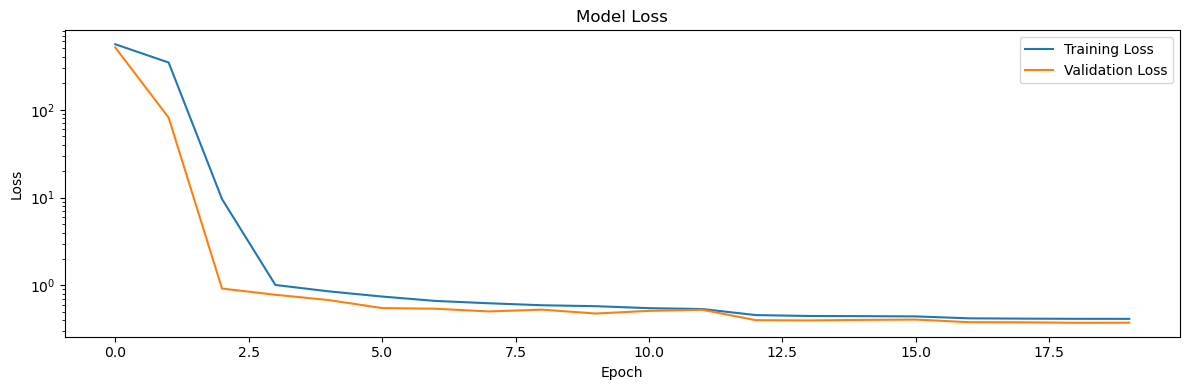

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Electrons - shape (1, 4, 15)
e_feats = np.array([
    [  # Event 0
        # Electron 0 (15 features)
        [65.2, 55.3, 1.2, 0.5, 1.1, 0.05, 0.15, 0.08, 6, 1, 1.5, 7, 0.45, 0.15, 35.0],
        # Electron 1 
        [48.7, 42.1, -0.8, 2.1, 0.9, -0.03, 0.08, 0.07, 5, 0, 0.9, 6, 0.52, 0.18, -42.0], 
        # Electron 2
        [37.1, 35.6, 0.5, -1.8, 1.3, 0.02, 0.11, 0.09, 7, 1, 1.2, 8, 0.38, 0.22, 15.0],
        # Electron 3 (padding - all zeros)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0]
    ],
    [  # Event 0
        # Electron 0 (15 features)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0],
        # Electron 1 
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0], 
        # Electron 2
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0],
        # Electron 3 (padding - all zeros)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0]
    ]
])

# Photons - shape (1, 4, 13)
p_feats = np.array([
    [  # Event 0
        # Photon 0 (13 features)
        [72.5, 68.3, 0.7, 1.2, 0.8, 12.5, 0.55, 0.12, 0.83, 0.91, 0.025, 0.015, 24.0],
        # Photon 1
        [63.1, 61.2, -1.1, -0.5, 0.9, 10.2, 0.48, 0.15, 0.78, 0.87, 0.031, 0.018, -18.0],
        # Photon 2 (padding - all zeros)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        # Photon 3 (padding - all zeros)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    ],
    [  # Event 0
        # Photon 0 (13 features)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        # Photon 1
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        # Photon 2 (padding - all zeros)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        # Photon 3 (padding - all zeros)
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    ]
])

# Vertex - shape (1, 3)
v_feats = np.array([
    [0.05, -0.03, 12.4], [0.0, 0.0, 0.0]  # x, y, z coordinates
])

In [96]:
e_feats_transformed, p_feats_transformed, v_feats_transformed = reader.transform_new_data(e_feats, p_feats, v_feats)

In [97]:
print(e_feats_transformed, p_feats_transformed, v_feats_transformed)

[[[ 1.59097474e+00  1.62705790e+00  4.78493591e-01  1.59154887e-01
    1.10000000e+00  5.00000000e-02  1.50000000e-01  8.00000000e-02
    2.77477172e+00  2.26772628e+00  1.66822786e+00  1.24570654e+00
    2.58125923e+00  2.49537196e+01  4.48486359e-02]
  [ 1.56164954e+00  1.60462253e+00 -3.21643342e-01  6.68450768e-01
    9.00000000e-01 -3.00000000e-02  8.00000000e-02  7.00000000e-02
    2.21405888e+00 -3.00438871e-01  1.51182443e+00  1.19477551e+00
    3.07491851e+00  3.00278616e+01 -5.17347392e-02]
  [ 1.52884413e+00  1.58833992e+00  1.98445664e-01 -5.72957942e-01
    1.30000000e+00  2.00000000e-02  1.10000000e-01  9.00000000e-02
    3.33548457e+00  2.26772628e+00  1.61353262e+00  1.28644253e+00
    2.08759994e+00  3.67933842e+01  1.97620449e-02]
  [-6.34503288e-01 -6.34618939e-01 -1.58856875e-03 -7.58910003e-08
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   -5.89505351e-01 -3.00438871e-01 -6.33984016e-01 -6.34877193e-01
   -5.92264747e-01 -4.16990332e-01  9.47